# Strategy 5 - LSTM

In this notebook, we will implement and test an LSTM-based strategy for price & returns prediction. This more sophisticated architecture should theoretically better capture long-term dependencies in time series.

In [79]:
import sys
import os

# Get the parent directory of the "notebook" folder
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add it to the Python path
sys.path.append(project_root)

from strategies.lstm_strategy import LSTMStrategy
from utils.backtest import Backtest
from utils.data_handler import DataHandler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## 5.1 Price prediction - 1 period ahead

### On a single stock

In [82]:
data_handler = DataHandler(ticker='AAPL', start_date='2010-01-01', end_date='2022-01-01')
data = data_handler.fetch_data()

[*********************100%***********************]  1 of 1 completed


In [83]:
data_handler = DataHandler(ticker='AAPL', start_date='2004-12-12', end_date='2015-12-12')
in_sample_data = data_handler.fetch_data()

lstm_strategy = LSTMStrategy(lookback=30, n_splits=5, epochs=30, n_days=1, predict_returns=False)
lstm_strategy.fit(in_sample_data)  # Trains the model and sets self.trained = True

# Print CV scores
print("Cross-validation MSE scores (in-sample):")
for i, score in enumerate(lstm_strategy.cv_scores, 1):
    print(f"Fold {i}: {score:.6f}")
print(f"\nMean MSE: {np.mean(lstm_strategy.cv_scores):.6f}")
print(f"Std MSE: {np.std(lstm_strategy.cv_scores):.6f}")


[*********************100%***********************]  1 of 1 completed


Cross-validation MSE scores (in-sample):
Fold 1: 0.000062
Fold 2: 0.000070
Fold 3: 0.000129
Fold 4: 0.000362
Fold 5: 0.001185

Mean MSE: 0.000362
Std MSE: 0.000426


[*********************100%***********************]  1 of 1 completed


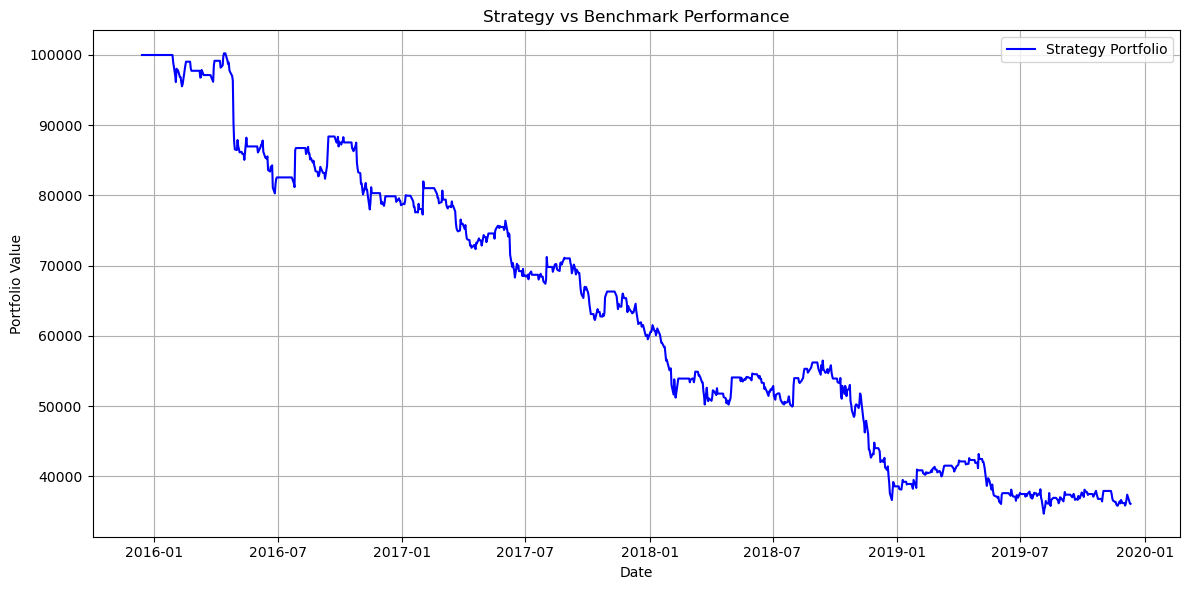

In [84]:
data_handler = DataHandler(ticker='AAPL', start_date='2015-12-12', end_date='2019-12-12')
out_sample_data = data_handler.fetch_data()

backtester = Backtest(out_sample_data, lstm_strategy)
results = backtester.run()

The results obviously look really bad, let's try on a few more stocks 

## 5.2 Backtesting : in sample training & out of sample performance

In [88]:
in_sample_start = "2004-12-31"
in_sample_end = '2015-12-30'
out_sample_start = '2015-12-31'
out_sample_end = '2019-12-31'

tickers = [
    "AAPL", "ABT", "ADI", "ADM", "ADP", "ADSK", "AEE", "AMD", "AME", "AMGN", "AMT", "AMZN", "AON",
    "FITB", "FRT", "GD", "GE", "GILD", "GIS", "GPC", "GWW", "HAL", "HAS"
] 

initial_cash = 100000
performance_summary = []
portfolio_series_list = []

for ticker in tickers:
    try:
        print(f"Processing {ticker}...")

        # Fetch data
        full_data_handler = DataHandler(ticker=ticker, start_date=in_sample_start, end_date=out_sample_end)
        full_data = full_data_handler.fetch_data()

        # Split into in-sample and out-of-sample
        in_sample_data = full_data[full_data.index <= in_sample_end]
        out_sample_data = full_data[(full_data.index >= out_sample_start) & (full_data.index <= out_sample_end)]

        if len(in_sample_data) < 100 or len(out_sample_data) < 100:
            print(f"Skipping {ticker} due to insufficient data.")
            continue

        # Train LSTM strategy on in-sample (predicting 1-day ahead returns)
        lstm_strategy = LSTMStrategy(lookback=30, n_splits=5, epochs=30, n_days=1, predict_returns=False)
        lstm_strategy.fit(in_sample_data)

        # Backtest on out-of-sample
        backtester = Backtest(out_sample_data, lstm_strategy, initial_cash=initial_cash, plot_results=False)
        results = backtester.run()
        portfolio_series = backtester.get_portfolio_value_series()

        # Store results
        performance_summary.append({
            'Ticker': ticker,
            **results
        })
        portfolio_series_list.append(portfolio_series.rename(ticker))

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

Processing AAPL...


[*********************100%***********************]  1 of 1 completed


Processing ABT...


[*********************100%***********************]  1 of 1 completed


Processing ADI...


[*********************100%***********************]  1 of 1 completed


Processing ADM...


[*********************100%***********************]  1 of 1 completed


Processing ADP...


[*********************100%***********************]  1 of 1 completed


Processing ADSK...


[*********************100%***********************]  1 of 1 completed


Processing AEE...


[*********************100%***********************]  1 of 1 completed


Processing AMD...


[*********************100%***********************]  1 of 1 completed


Processing AME...


[*********************100%***********************]  1 of 1 completed


Processing AMGN...


[*********************100%***********************]  1 of 1 completed


Processing AMT...


[*********************100%***********************]  1 of 1 completed


Processing AMZN...


[*********************100%***********************]  1 of 1 completed


Processing AON...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing FITB...



[*********************100%***********************]  1 of 1 completed

Processing FRT...



[*********************100%***********************]  1 of 1 completed

Processing GD...



[*********************100%***********************]  1 of 1 completed

Processing GE...



[*********************100%***********************]  1 of 1 completed

Processing GILD...



[*********************100%***********************]  1 of 1 completed

Processing GIS...



[*********************100%***********************]  1 of 1 completed

Processing GPC...


Processing GWW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Processing HAL...



[*********************100%***********************]  1 of 1 completed

Processing HAS...


In [97]:
# Create final summary DataFrame and portfolio time series DataFrame
performance_df = pd.DataFrame(performance_summary)
portfolio_df = pd.concat(portfolio_series_list, axis=1)

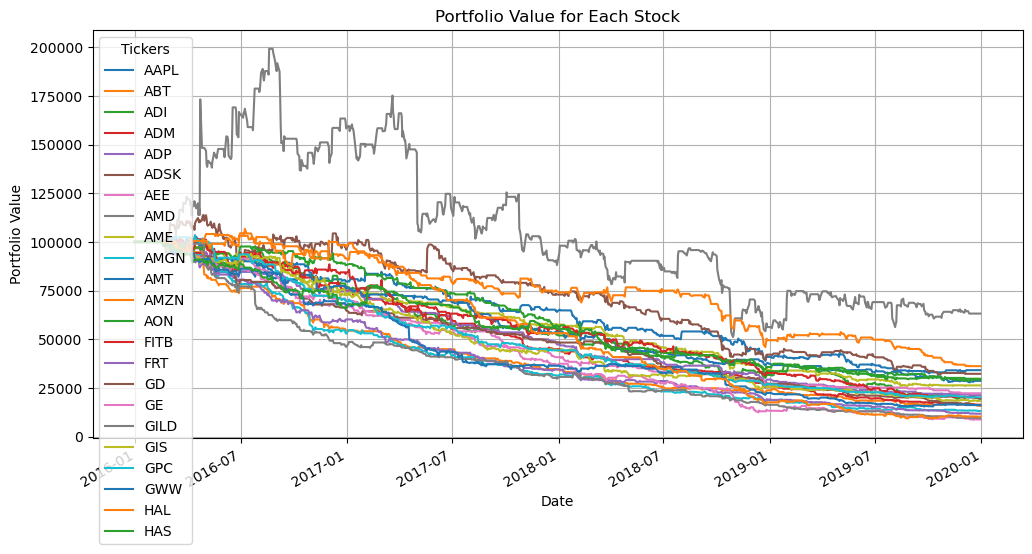

In [99]:
# Combine all portfolio series
combined_portfolio = pd.concat(portfolio_series_list, axis=1)
combined_portfolio.plot(figsize=(12, 6))
plt.title('Portfolio Value for Each Stock')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Tickers')
plt.grid(True)
plt.show()

In [100]:
# Create DataFrame
perf_df = pd.DataFrame(performance_summary)

# Summary statistics
print("\n=== Summary Statistics ===")
print(perf_df.describe().round(3))

# Mean values
mean_metrics = perf_df[['Return', 'Sharpe Ratio', 'Final Value', 'Max Drawdown']].mean()
print("\n=== Mean Metrics ===")
print(mean_metrics.round(3))


=== Summary Statistics ===
       Final Value  Return  Sharpe Ratio  Max Drawdown
count       23.000  23.000        23.000        23.000
mean     22528.121  -0.775        -2.400        -0.798
std      11950.785   0.120         0.910         0.075
min       8762.226  -0.912        -3.693        -0.913
25%      15959.439  -0.840        -3.041        -0.844
50%      19675.784  -0.803        -2.371        -0.809
75%      28900.474  -0.711        -2.052        -0.735
max      63198.939  -0.368         0.003        -0.653

=== Mean Metrics ===
Return             -0.775
Sharpe Ratio       -2.400
Final Value     22528.121
Max Drawdown       -0.798
dtype: float64


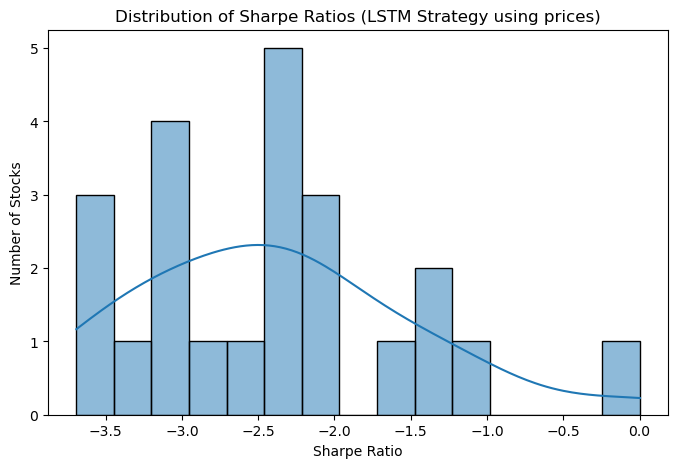

In [103]:
plt.figure(figsize=(8, 5))
sns.histplot(perf_df['Sharpe Ratio'], kde=True, bins=15)
plt.title('Distribution of Sharpe Ratios (LSTM Strategy using prices)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Number of Stocks')
plt.show()


## 5.3 Return Prediction - 1 period ahead

### On a Single stock

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Cross-validation MSE scores (in-sample):
Fold 1: 0.006517
Fold 2: 0.008477
Fold 3: 0.002945
Fold 4: 0.003322
Fold 5: 0.002342

Mean MSE: 0.004721
Std MSE: 0.002371


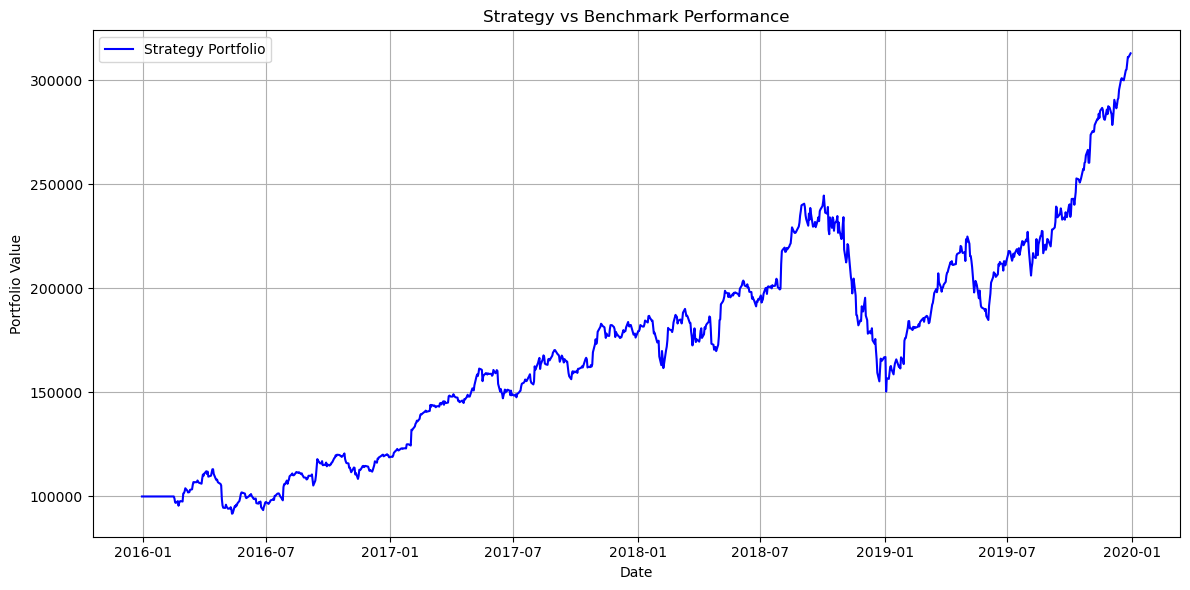


Out-of-sample Backtest Results:
Final Value: 313048.4199
Return: 2.1305
Sharpe Ratio: 1.3387
Max Drawdown: -0.3851
CPU times: total: 2min 51s
Wall time: 1min 32s


In [35]:
%%time

# In-sample training (return-based prediction, 1 day ahead)
data_handler = DataHandler(ticker='AAPL', start_date='2004-12-12', end_date='2015-12-12')
in_sample_data = data_handler.fetch_data()

# Predict 1-day ahead returns instead of prices
lstm_strategy_return = LSTMStrategy(lookback=30, n_splits=5, epochs=30, n_days=1, predict_returns=True)
lstm_strategy_return.fit(in_sample_data)  # Trains once

# Print CV scores
print("Cross-validation MSE scores (in-sample):")
for i, score in enumerate(lstm_strategy_return.cv_scores, 1):
    print(f"Fold {i}: {score:.6f}")
print(f"\nMean MSE: {np.mean(lstm_strategy_return.cv_scores):.6f}")
print(f"Std MSE: {np.std(lstm_strategy_return.cv_scores):.6f}")


data_handler = DataHandler(ticker='AAPL', start_date='2015-12-31', end_date='2019-12-31')
out_sample_data = data_handler.fetch_data()

backtester = Backtest(out_sample_data, lstm_strategy_return)
results_return = backtester.run()

# Print results
print("\nOut-of-sample Backtest Results:")
for key, value in results_return.items():
    print(f"{key}: {value:.4f}")


This is an excellent results, even too good to be true ? Let's run the model on all stocks ! 

## 5.4 Backtesting : in sample training & out of sample performance

In [63]:
in_sample_start = "2004-12-31"
in_sample_end = '2015-12-30'
out_sample_start = '2015-12-31'
out_sample_end = '2019-12-31'

tickers = [
    "AAPL", "ABT", "ADI", "ADM", "ADP", "ADSK", "AEE", "AEP", "AJG", "AKAM",
    "ALB", "AMAT", "AMD", "AME", "AMGN", "AMT", "AMZN", "AON", "AOS", "APA",
    "APD", "APH", "ARE", "AVB", "AVY", "AXP", "AZO", "BA", "BAC", "BAX",
    "BBY", "BDX", "BEN", "BIIB", "BK", "BLK", "BMY", "BSX", "BXP", "C",
    "CAG", "CAH", "CAT", "CB", "CCI", "CDNS", "CHD", "CHRW", "CINF", "CL",
    "CLX", "CMI", "CNP", "COO", "COP", "COST", "CPB", "CPRT", "CSCO", "CTAS",
    "CTSH", "D", "DE", "DGX", "DHI", "DIS", "DLTR", "DOV", "DRI", "DTE",
    "DVA", "EA", "EBAY", "ECL", "ED", "EFX", "EIX", "EL", "EMN", "EMR",
    "EOG", "EQR", "ES", "ESS", "F", "FAST", "FCX", "FDX", "FE", "FFIV",
    "FITB", "FRT", "GD", "GE", "GILD", "GIS", "GPC", "GWW", "HAL", "HAS"
] 

initial_cash = 100000
performance_summary = []
portfolio_series_list = []

for ticker in tickers:
    try:
        print(f"Processing {ticker}...")

        # Fetch data
        full_data_handler = DataHandler(ticker=ticker, start_date=in_sample_start, end_date=out_sample_end)
        full_data = full_data_handler.fetch_data()

        # Split into in-sample and out-of-sample
        in_sample_data = full_data[full_data.index <= in_sample_end]
        out_sample_data = full_data[(full_data.index >= out_sample_start) & (full_data.index <= out_sample_end)]

        if len(in_sample_data) < 100 or len(out_sample_data) < 100:
            print(f"Skipping {ticker} due to insufficient data.")
            continue

        # Train LSTM strategy on in-sample (predicting 1-day ahead returns)
        lstm_strategy = LSTMStrategy(lookback=30, n_splits=5, epochs=30, n_days=1, predict_returns=True)
        lstm_strategy.fit(in_sample_data)

        # Backtest on out-of-sample
        backtester = Backtest(out_sample_data, lstm_strategy, initial_cash=initial_cash, plot_results=False)
        results = backtester.run()
        portfolio_series = backtester.get_portfolio_value_series()

        # Store results
        performance_summary.append({
            'Ticker': ticker,
            **results
        })
        portfolio_series_list.append(portfolio_series.rename(ticker))

    except Exception as e:
        print(f"Error processing {ticker}: {e}")

[*********************100%***********************]  1 of 1 completed

Processing AAPL...



[*********************100%***********************]  1 of 1 completed

Processing ABT...



[*********************100%***********************]  1 of 1 completed

Processing ADI...



[*********************100%***********************]  1 of 1 completed

Processing ADM...


Processing ADP...


[*********************100%***********************]  1 of 1 completed


Processing ADSK...


[*********************100%***********************]  1 of 1 completed


Processing AEE...


[*********************100%***********************]  1 of 1 completed


Processing AEP...


[*********************100%***********************]  1 of 1 completed


Processing AJG...


[*********************100%***********************]  1 of 1 completed


Processing AKAM...


[*********************100%***********************]  1 of 1 completed


Processing ALB...


[*********************100%***********************]  1 of 1 completed


Processing AMAT...


[*********************100%***********************]  1 of 1 completed


Processing AMD...


[*********************100%***********************]  1 of 1 completed


Processing AME...


[*********************100%***********************]  1 of 1 completed


Processing AMGN...


[*********************100%***********************]  1 of 1 completed


Processing AMT...


[*********************100%***********************]  1 of 1 completed


Processing AMZN...


[*********************100%***********************]  1 of 1 completed


Processing AON...


[*********************100%***********************]  1 of 1 completed


Processing AOS...


[*********************100%***********************]  1 of 1 completed


Processing APA...


[*********************100%***********************]  1 of 1 completed


Processing APD...


[*********************100%***********************]  1 of 1 completed


Processing APH...


[*********************100%***********************]  1 of 1 completed


Processing ARE...


[*********************100%***********************]  1 of 1 completed


Processing AVB...


[*********************100%***********************]  1 of 1 completed


Processing AVY...


[*********************100%***********************]  1 of 1 completed


Processing AXP...


[*********************100%***********************]  1 of 1 completed


Processing AZO...


[*********************100%***********************]  1 of 1 completed


Processing BA...


[*********************100%***********************]  1 of 1 completed


Processing BAC...


[*********************100%***********************]  1 of 1 completed


Processing BAX...


[*********************100%***********************]  1 of 1 completed


Processing BBY...


[*********************100%***********************]  1 of 1 completed


Processing BDX...


[*********************100%***********************]  1 of 1 completed


Processing BEN...


[*********************100%***********************]  1 of 1 completed


Processing BIIB...


[*********************100%***********************]  1 of 1 completed


Processing BK...


[*********************100%***********************]  1 of 1 completed


Processing BLK...


[*********************100%***********************]  1 of 1 completed


Processing BMY...


[*********************100%***********************]  1 of 1 completed


Processing BSX...


[*********************100%***********************]  1 of 1 completed


Processing BXP...


[*********************100%***********************]  1 of 1 completed


Processing C...


[*********************100%***********************]  1 of 1 completed


Processing CAG...


[*********************100%***********************]  1 of 1 completed


Processing CAH...


[*********************100%***********************]  1 of 1 completed


Processing CAT...


[*********************100%***********************]  1 of 1 completed


Processing CB...


[*********************100%***********************]  1 of 1 completed


Processing CCI...


[*********************100%***********************]  1 of 1 completed


Processing CDNS...


[*********************100%***********************]  1 of 1 completed


Processing CHD...


[*********************100%***********************]  1 of 1 completed


Processing CHRW...


[*********************100%***********************]  1 of 1 completed


Processing CINF...


[*********************100%***********************]  1 of 1 completed


Processing CL...


[*********************100%***********************]  1 of 1 completed


Processing CLX...


[*********************100%***********************]  1 of 1 completed


Processing CMI...


[*********************100%***********************]  1 of 1 completed


Processing CNP...


[*********************100%***********************]  1 of 1 completed


Processing COO...


[*********************100%***********************]  1 of 1 completed


Processing COP...


[*********************100%***********************]  1 of 1 completed


Processing COST...


[*********************100%***********************]  1 of 1 completed


Processing CPB...


[*********************100%***********************]  1 of 1 completed


Processing CPRT...


[*********************100%***********************]  1 of 1 completed


Processing CSCO...


[*********************100%***********************]  1 of 1 completed


Processing CTAS...


[*********************100%***********************]  1 of 1 completed


Processing CTSH...


[*********************100%***********************]  1 of 1 completed


Processing D...


[*********************100%***********************]  1 of 1 completed


Processing DE...


[*********************100%***********************]  1 of 1 completed


Processing DGX...


[*********************100%***********************]  1 of 1 completed


Processing DHI...


[*********************100%***********************]  1 of 1 completed


Processing DIS...


[*********************100%***********************]  1 of 1 completed


Processing DLTR...


[*********************100%***********************]  1 of 1 completed


Processing DOV...


[*********************100%***********************]  1 of 1 completed


Processing DRI...


[*********************100%***********************]  1 of 1 completed


Processing DTE...


[*********************100%***********************]  1 of 1 completed


Processing DVA...


[*********************100%***********************]  1 of 1 completed


Processing EA...


[*********************100%***********************]  1 of 1 completed


Processing EBAY...


[*********************100%***********************]  1 of 1 completed


Processing ECL...


[*********************100%***********************]  1 of 1 completed


Processing ED...


[*********************100%***********************]  1 of 1 completed


Processing EFX...


[*********************100%***********************]  1 of 1 completed


Processing EIX...


[*********************100%***********************]  1 of 1 completed


Processing EL...


[*********************100%***********************]  1 of 1 completed


Processing EMN...


[*********************100%***********************]  1 of 1 completed


Processing EMR...


[*********************100%***********************]  1 of 1 completed


Processing EOG...


[*********************100%***********************]  1 of 1 completed


Processing EQR...


[*********************100%***********************]  1 of 1 completed


Processing ES...


[*********************100%***********************]  1 of 1 completed


Processing ESS...


[*********************100%***********************]  1 of 1 completed


Processing F...


[*********************100%***********************]  1 of 1 completed


Processing FAST...


[*********************100%***********************]  1 of 1 completed


Processing FCX...


[*********************100%***********************]  1 of 1 completed


Processing FDX...


[*********************100%***********************]  1 of 1 completed


Processing FE...


[*********************100%***********************]  1 of 1 completed


Processing FFIV...


[*********************100%***********************]  1 of 1 completed


Processing FITB...


[*********************100%***********************]  1 of 1 completed


Processing FRT...


[*********************100%***********************]  1 of 1 completed


Processing GD...


[*********************100%***********************]  1 of 1 completed


Processing GE...


[*********************100%***********************]  1 of 1 completed


Processing GILD...


[*********************100%***********************]  1 of 1 completed


Processing GIS...


[*********************100%***********************]  1 of 1 completed


Processing GPC...


[*********************100%***********************]  1 of 1 completed


Processing GWW...


[*********************100%***********************]  1 of 1 completed


Processing HAL...


[*********************100%***********************]  1 of 1 completed


Processing HAS...


[*********************100%***********************]  1 of 1 completed


In [64]:
# Create final summary DataFrame and portfolio time series DataFrame
performance_df = pd.DataFrame(performance_summary)
portfolio_df = pd.concat(portfolio_series_list, axis=1)

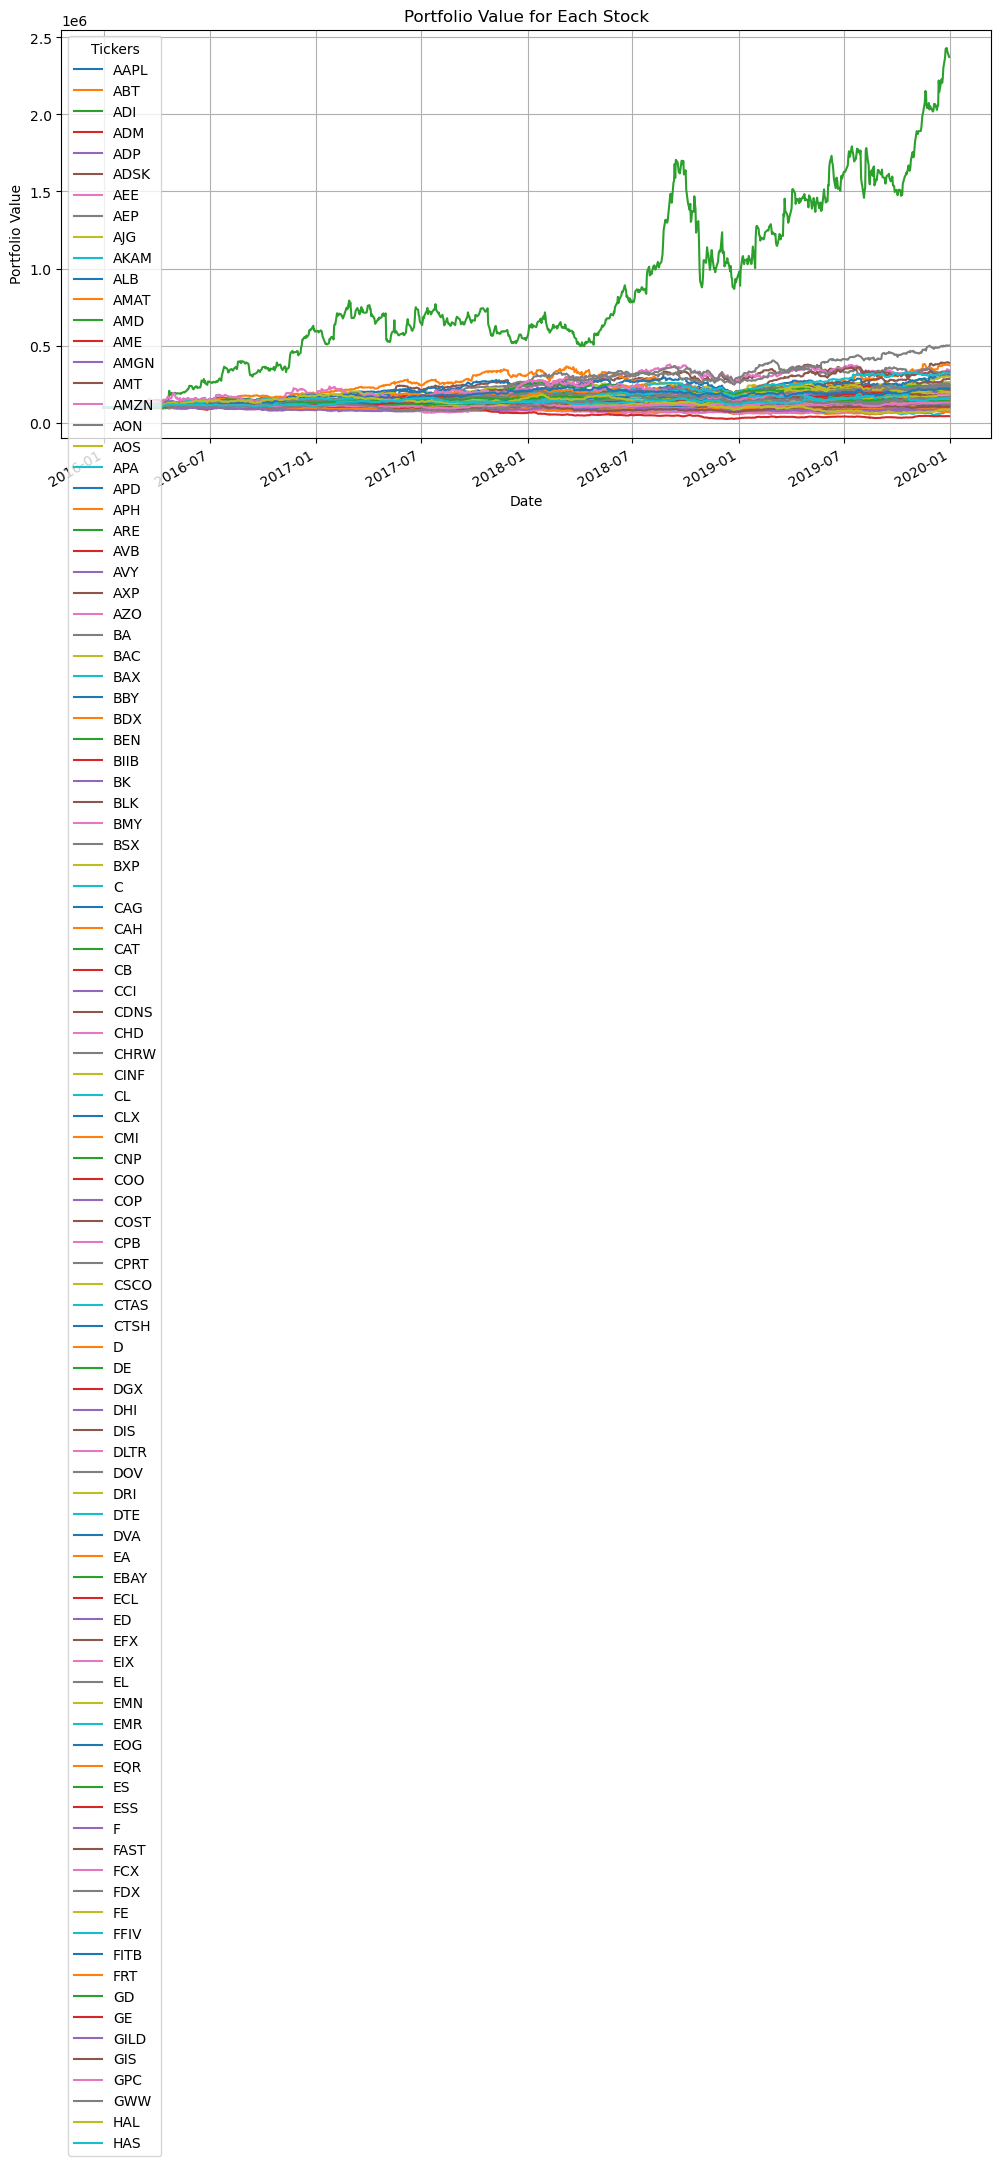

In [65]:
# Combine all portfolio series
combined_portfolio = pd.concat(portfolio_series_list, axis=1)
combined_portfolio.plot(figsize=(12, 6))
plt.title('Portfolio Value for Each Stock')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend(title='Tickers')
plt.grid(True)
plt.show()

In [77]:
# Create DataFrame
perf_df = pd.DataFrame(performance_summary)

# Summary statistics
print("\n=== Summary Statistics ===")
print(perf_df.describe().round(3))

# Mean values
mean_metrics = perf_df[['Return', 'Sharpe Ratio', 'Final Value', 'Max Drawdown']].mean()
print("\n=== Mean Metrics ===")
print(mean_metrics.round(3))


=== Summary Statistics ===
       Final Value   Return  Sharpe Ratio  Max Drawdown
count      100.000  100.000       100.000       100.000
mean    207250.794    1.073         0.761        -0.308
std     231379.558    2.314         0.449         0.133
min      42811.073   -0.572        -0.531        -0.780
25%     137472.009    0.375         0.487        -0.385
50%     174496.573    0.745         0.779        -0.276
75%     222094.420    1.221         1.089        -0.206
max    2372048.135   22.720         1.880        -0.115

=== Mean Metrics ===
Return               1.073
Sharpe Ratio         0.761
Final Value     207250.794
Max Drawdown        -0.308
dtype: float64


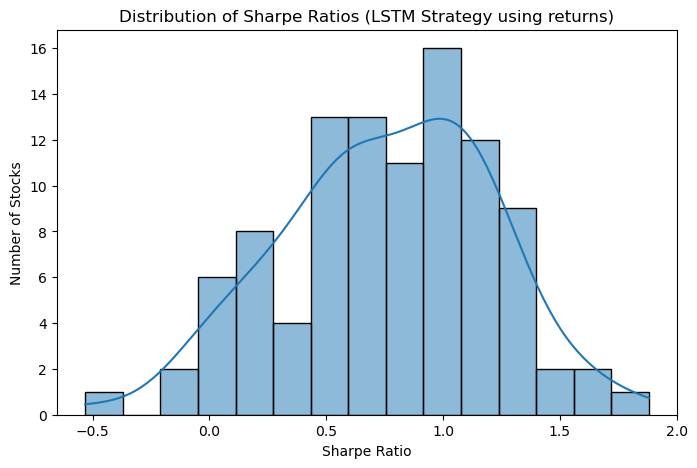

In [67]:
plt.figure(figsize=(8, 5))
sns.histplot(perf_df['Sharpe Ratio'], kde=True, bins=15)
plt.title('Distribution of Sharpe Ratios (LSTM Strategy using returns)')
plt.xlabel('Sharpe Ratio')
plt.ylabel('Number of Stocks')
plt.show()
